# Testing How Best To Determine Point Removal

In [35]:
import os
import tsplib95
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import signal
import tqdm
from multiprocess import Pool
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.colors import *
from scipy.stats import ttest_ind


from wsp import tsp, ds

INCLUDE_LEAVES = False
# FILE_DIR = "DATA_GEN_20p0.25"
FILE_DIR = "DATA_GEN_50u"
AX = np.array([None, None])
S_FACTOR = 8.0
S_FACTOR_B = 2.0
TREE_TYPE = ds.PKPRQuadTree

In [3]:
top_problems = sorted(os.listdir(FILE_DIR))

len(top_problems)

1000

## Problem Injestion

In [4]:
def filter_leaves(decomp):
    return all(not tree.leaf for tree in decomp[0]) if not INCLUDE_LEAVES else True

def count_wspd(wspd):
    return sum(1 for x in wspd if filter_leaves(x))

def rel_diff(a,b):
    return float('nan') if a == 0 and b == 0 else (a - b) / (a + b)

In [5]:
base_df = pd.DataFrame(columns=['name', 'parent', 'path_reduction', 'path_discount', 'optimal_percent', 'wsp_reduction', 'wsp_reduction_B', 'wsp_spec_reduction', 'wsp_spec_reduction_B', 'point_specific_wsp', 'point_specific_wsp_B', 'point_specific_wsp_weighted', 'point_specific_wsp_weighted_B', 'point_average_cost', 'point_maximum_cost', 'point_minimum_cost', 'point_average_cost_weighted', 'point_maximum_cost_weighted', 'point_minimum_cost_weighted'])
base_df = base_df.astype({'name': str, 'parent': str, 'path_reduction': float, 'path_discount': float, 'optimal_percent': float, 'wsp_reduction': float, 'wsp_reduction_B': float, 'wsp_spec_reduction': float, 'wsp_spec_reduction_B': float, 'point_specific_wsp': float, 'point_specific_wsp_B': float, 'point_specific_wsp_weighted': float, 'point_specific_wsp_weighted_B': float, 'point_average_cost': float, 'point_maximum_cost': float, 'point_minimum_cost': float, 'point_average_cost_weighted': float, 'point_maximum_cost_weighted': float, 'point_minimum_cost_weighted': float})
base_df.set_index('name', inplace=True)

In [6]:
removed_problems : list[tsplib95.models.StandardProblem] = []
def setup(top_problem):
    main_problem = tsplib95.load(f"{FILE_DIR}/{top_problem}/{top_problem}.tsp")
    main_conc_cost = float(main_problem.comment.split(' ')[2])
    main_points = [ds.Point(*main_problem.node_coords[i]) for i in main_problem.get_nodes()]
    
    main_problem_object = tsp.TravellingSalesmanProblem[TREE_TYPE](TREE_TYPE, main_points, AX, s=S_FACTOR)
    main_problem_object_B = tsp.TravellingSalesmanProblem[TREE_TYPE](TREE_TYPE, main_points, AX, s=S_FACTOR_B)
    
    main_cost = main_problem_object.calc_dist(
        [main_points[i-1] for i in main_problem.tours[0]] + [main_points[main_problem.tours[0][0] - 1]]
    )

    updates = base_df.copy()
    
    best_discount = float('inf')
    for removal_name in os.listdir(f"{FILE_DIR}/{top_problem}"):
        if '_' not in removal_name: continue
        point_number = int(removal_name.split('_')[-1].split('.')[0]) # number of the missing point in the og

        sub_problem = tsplib95.load(f"{FILE_DIR}/{top_problem}/{removal_name}")
        sub_conc_cost = float(sub_problem.comment.split(' ')[2])
        sub_points = [ds.Point(*sub_problem.node_coords[i]) for i in sub_problem.get_nodes()]
        sub_problem_object = tsp.TravellingSalesmanProblem[TREE_TYPE](TREE_TYPE, sub_points, AX, s=S_FACTOR)
        sub_problem_object_B = tsp.TravellingSalesmanProblem[TREE_TYPE](TREE_TYPE, sub_points, AX, s=S_FACTOR_B)
        sub_cost = sub_problem_object.calc_dist(
            [sub_points[i-1] for i in sub_problem.tours[0]] + [sub_points[sub_problem.tours[0][0] - 1]]
        )

        point_specific_wsp = sum(
            sum(1 for connectionTree in connections if (not connectionTree.leaf) or INCLUDE_LEAVES)
            for tree, connections in main_problem_object.single_indexable_wspd.items()
            if (INCLUDE_LEAVES or not tree.leaf) and main_points[point_number - 1] in tree
        )
        point_specific_wsp_B = sum(
            sum(1 for connectionTree in connections if connectionTree.leaf or INCLUDE_LEAVES)
            for tree, connections in main_problem_object_B.single_indexable_wspd.items()
            if (INCLUDE_LEAVES or not tree.leaf) and main_points[point_number - 1] in tree
        )
        
        # point_specific_wsp_sep_sum = sum(
        #     len(connections) if main_points[point_number - 1] in tree else 0
        #     for tree, connections in sub_problem_object.single_indexable_wspd.items()
        
        point_edge_costs = main_problem_object.dist_matrix_with_nan[point_number - 1]
        
        best_discount = min(best_discount, (sub_conc_cost / main_conc_cost))

        updates.loc[sub_problem.name] = {
            'parent': top_problem,
            'path_reduction': sub_conc_cost / main_conc_cost,
            'path_discount': 1.0 - (sub_conc_cost / main_conc_cost),
            'wsp_spec_reduction': rel_diff(count_wspd(main_problem_object.wspd), count_wspd(sub_problem_object.wspd)),
            'wsp_spec_reduction_B': rel_diff(count_wspd(main_problem_object_B.wspd), count_wspd(sub_problem_object_B.wspd)),
            'point_specific_wsp': point_specific_wsp,
            'point_specific_wsp_B': point_specific_wsp_B,
            'point_specific_wsp_weighted': point_specific_wsp / (count_wspd(main_problem_object.wspd) + 0.01),
            'point_specific_wsp_weighted_B': point_specific_wsp_B / (count_wspd(main_problem_object_B.wspd) + 0.01),
            'point_average_cost': np.nanmean(point_edge_costs),
            'point_maximum_cost': np.nanmax(point_edge_costs),
            'point_minimum_cost': np.nanmin(point_edge_costs),
            'point_average_cost_weighted': np.nanmean(point_edge_costs) / main_cost,
            'point_maximum_cost_weighted': np.nanmax(point_edge_costs) / main_cost,
            'point_minimum_cost_weighted': np.nanmin(point_edge_costs) / main_cost,
        }
    updates['optimal_percent'] = updates['path_discount'] / best_discount
    return updates

original_sigint_handler = signal.signal(signal.SIGINT, signal.SIG_IGN)
pool = Pool(7) # NUMBER OF PROCESSES
signal.signal(signal.SIGINT, original_sigint_handler)

update_collection = []
u=0
try:
    with tqdm.tqdm(total=len(top_problems), unit="top problem") as pbar:
        for result in pool.imap_unordered(setup, top_problems):
            update_collection.append(result)
            pbar.update(1)
            prob_name = next(iter(result))
            u += 1
            # if result[prob_name] != {}:
            #     u += 1
            #     # pbar.set_postfix(pf := {**pf, **{"last": prob_name, "last_updated": prob_name, "updated": u}})
            # else:
            #     # pbar.set_postfix(pf := {**pf, **{"last": prob_name}})
except KeyboardInterrupt:
    print("Caught KeyboardInterrupt, terminating workers")
    pool.terminate()
else:
    pool.close()
pool.join()

print("Injesting updates")
reduction_df = pd.concat(update_collection)
reduction_df

100%|██████████| 1000/1000 [01:52<00:00,  8.85top problem/s]


Injesting updates


,parent,path_reduction,path_discount,optimal_percent,wsp_reduction,wsp_reduction_B,wsp_spec_reduction,wsp_spec_reduction_B,point_specific_wsp,point_specific_wsp_B,point_specific_wsp_weighted,point_specific_wsp_weighted_B,point_average_cost,point_maximum_cost,point_minimum_cost,point_average_cost_weighted,point_maximum_cost_weighted,point_minimum_cost_weighted
name,,,,,,,,,,,,,,,,,,
aad50u_16,aad50u,0.997798,0.002202,0.002331,NaN,NaN,-0.076923,0.000000,1,5,0.033322,0.070413,4376.997178,9480.812834,435.183869,0.075897,0.164398,0.007546
aad50u_4,aad50u,0.998405,0.001595,0.001689,NaN,NaN,0.111111,0.083969,6,11,0.199933,0.154908,4894.349058,8858.516637,735.312859,0.084868,0.153607,0.012750
aad50u_5,aad50u,0.999185,0.000815,0.000863,NaN,NaN,0.071429,0.028986,4,12,0.133289,0.168990,4066.340064,7575.575556,451.453209,0.070510,0.131361,0.007828
aad50u_17,aad50u,0.998387,0.001613,0.001707,NaN,NaN,0.090909,0.007092,6,12,0.199933,0.168990,4235.493536,9091.319431,262.840256,0.073444,0.157644,0.004558
aad50u_29,aad50u,0.994486,0.005514,0.005838,NaN,NaN,0.000000,-0.006993,3,7,0.099967,0.098578,4363.622482,8778.322220,977.896723,0.075665,0.152216,0.016957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bml50u_8,bml50u,0.994627,0.005373,0.005585,NaN,NaN,0.000000,0.000000,0,3,0.000000,0.036581,6211.741015,9792.106617,1654.786995,0.116297,0.183329,0.030981
bml50u_22,bml50u,0.982831,0.017169,0.017844,NaN,NaN,0.000000,-0.006061,0,2,0.000000,0.024387,5463.519733,10977.349862,801.355102,0.102289,0.205520,0.015003
bml50u_36,bml50u,0.994027,0.005973,0.006207,NaN,NaN,-0.056911,0.025000,8,7,0.137907,0.085355,5738.957590,10631.827736,721.208014,0.107446,0.199051,0.013503


In [7]:
reduction_df['wsp_spec_reduction'].describe(), reduction_df['wsp_spec_reduction'].isna().sum()
# reduction_df = reduction_df[reduction_df['wsp_spec_reduction'].notna()]

(count    50000.000000
 mean         0.027412
 std          0.052334
 min         -0.419355
 25%          0.000000
 50%          0.000000
 75%          0.066667
 max          0.518519
 Name: wsp_spec_reduction, dtype: float64,
 np.int64(0))

## WSP Reduction Calculations
How much does the difference in global well seperated pairs actually predict anything

In [8]:
results = sm.OLS(reduction_df["path_reduction"], sm.add_constant(reduction_df["wsp_spec_reduction"])).fit()
print(results.summary())

results_B = sm.OLS(reduction_df["path_reduction"], sm.add_constant(reduction_df[["wsp_spec_reduction", "wsp_spec_reduction_B"]])).fit()
results_B.summary()

                            OLS Regression Results                            
Dep. Variable:         path_reduction   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     2075.
Date:                Sun, 08 Jun 2025   Prob (F-statistic):               0.00
Time:                        16:31:38   Log-Likelihood:             1.6092e+05
No. Observations:               50000   AIC:                        -3.218e+05
Df Residuals:                   49998   BIC:                        -3.218e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.9901   4.89

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     1482.
Date:                Sun, 08 Jun 2025   Prob (F-statistic):               0.00
Time:                        16:31:38   Log-Likelihood:             1.6134e+05
No. Observations:               50000   AIC:                        -3.227e+05
Df Residuals:                   49997   BIC:                        -3.227e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.9905   5.05e-05   1.96e+04      0.000       0.990       0.991
wsp_spec_reduction       0.0529      0.001     54.437      0.000       0.051       0.055
wsp_spec_reduction_B    -0.0487      0.002    -29.210      0.000      -0.052      -0.045
==============================================================================
Omnibus:                    21886.944   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           128141.540
Skew:                          -2.046   Prob(JB):                         0.00
Kurtosis:                       9.691   Cond. No.                         41.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
results2 = smf.ols(formula="path_reduction ~ wsp_spec_reduction + I(wsp_spec_reduction**2)", data=reduction_df).fit()
print(results2.summary())

results2_B = smf.ols(formula="path_reduction ~ wsp_spec_reduction + I(wsp_spec_reduction**2) + wsp_spec_reduction_B + I(wsp_spec_reduction_B**2)", data=reduction_df).fit()
results2_B.summary()

                            OLS Regression Results                            
Dep. Variable:         path_reduction   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     1502.
Date:                Sun, 08 Jun 2025   Prob (F-statistic):               0.00
Time:                        16:31:38   Log-Likelihood:             1.6136e+05
No. Observations:               50000   AIC:                        -3.227e+05
Df Residuals:                   49997   BIC:                        -3.227e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     1138.
Date:                Sun, 08 Jun 2025   Prob (F-statistic):               0.00
Time:                        16:31:38   Log-Likelihood:             1.6208e+05
No. Observations:               50000   AIC:                        -3.242e+05
Df Residuals:                   49995   BIC:                        -3.241e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.9909   5.09e-05   1.95e+04      0.000       0.991       0.991
wsp_spec_reduction               0.0591      0.001     51.239      0.000       0.057       0.061
I(wsp_spec_reduction ** 2)      -0.1328      0.007    -18.875      0.000      -0.147      -0.119
wsp_spec_reduction_B            -0.0139      0.002     -5.912      0.000      -0.019      -0.009
I(wsp_spec_reduction_B ** 2)    -0.5675      0.026    -22.118      0.000      -0.618      -0.517
==============================================================================
Omnibus:                    21163.408   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           123216.278
Skew:                          -1.966   Prob(JB):                         0.00
Kurtosis:                       9.609   Cond. No.                         613.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_64028/1037681458.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = results.params[0] + (results.params[1] * x)
/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_64028/1037681458.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2


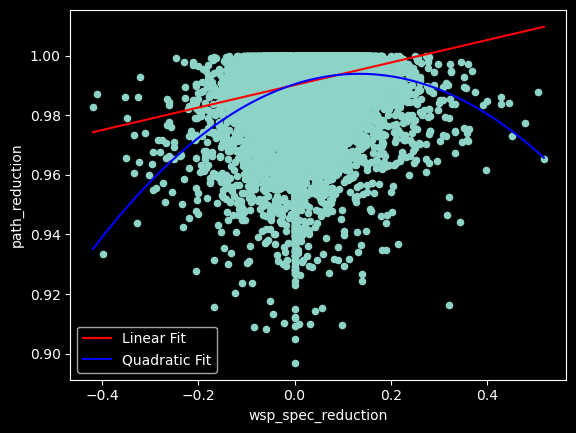

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_64028/1037681458.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.params[0]


np.float64(0.9901332633568147)

In [10]:
reduction_df.plot.scatter("wsp_spec_reduction", "path_reduction")
# Plot the first fitted model
x = np.linspace(reduction_df["wsp_spec_reduction"].min(), reduction_df["wsp_spec_reduction"].max(), 100)
y = results.params[0] + (results.params[1] * x)
plt.plot(x, y, color='red', label='Linear Fit')

# Plot the second fitted model
y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2
plt.plot(x, y2, color='blue', label='Quadratic Fit')

plt.legend()
plt.show()
results.params[0]

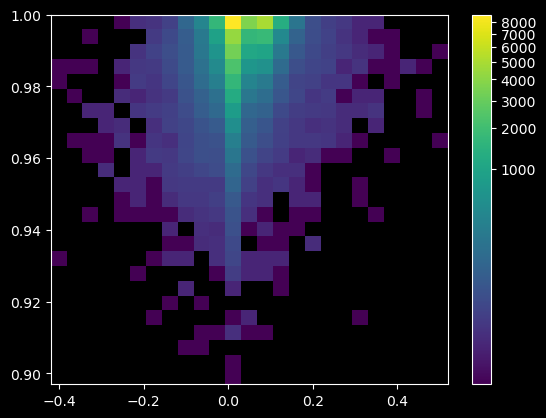

In [11]:
h = plt.hist2d(reduction_df["wsp_spec_reduction"], reduction_df["path_reduction"], bins=(25,25), cmin=1, norm=PowerNorm(0.25))
plt.colorbar(h[3])

In [36]:
COMPARISON_SIZE = 5
path_smallest = reduction_df.groupby("parent").apply(lambda df: df.nsmallest(COMPARISON_SIZE, 'path_reduction'))
path_largest = reduction_df.groupby("parent").apply(lambda df: df.nlargest(COMPARISON_SIZE, 'path_reduction'))

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_64028/1926063946.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  path_smallest = reduction_df.groupby("parent").apply(lambda df: df.nsmallest(COMPARISON_SIZE, 'path_reduction'))
/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_64028/1926063946.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  path_largest = reduction_df.groupby("pare

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_64028/1986339396.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = results.params[0] + (results.params[1] * x)
/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_64028/1986339396.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     44.23
Date:                Sun, 08 Jun 2025   Prob (F-statistic):           9.08e-20
Time:                        17:11:06   Log-Likelihood:                 15556.
No. Observations:                5000   AIC:                        -3.111e+04
Df Residuals:                    4997   BIC:                        -3.109e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.9693      0.000   6067.799      0.000       0.969       0.970
wsp_spec_reduction             0.0194      0.002      7.964      0.000       0.015       0.024
I(wsp_spec_reduction ** 2)    -0.0763      0.012     -6.556      0.000      -0.099      -0.053
==============================================================================
Omnibus:                     1697.532   Durbin-Watson:                   1.709
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6221.992
Skew:                          -1.680   Prob(JB):                         0.00
Kurtosis:                       7.310   Cond. No.                         76.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

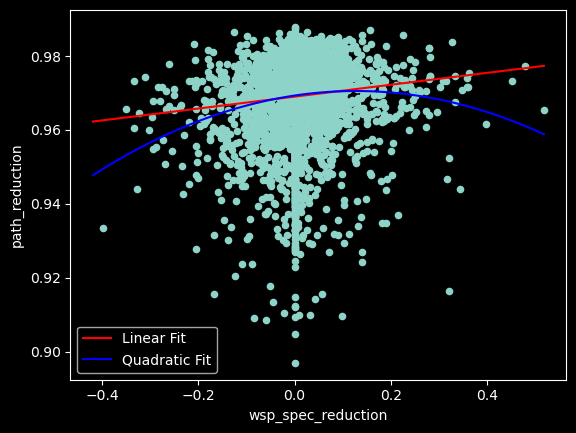

In [37]:
path_smallest.plot.scatter("wsp_spec_reduction", "path_reduction")
results = sm.OLS(path_smallest["path_reduction"], sm.add_constant(path_smallest["wsp_spec_reduction"])).fit()

x = np.linspace(reduction_df["wsp_spec_reduction"].min(), reduction_df["wsp_spec_reduction"].max(), 100)
y = results.params[0] + (results.params[1] * x)
plt.plot(x, y, color='red', label='Linear Fit')

results2 = smf.ols(formula="path_reduction ~ wsp_spec_reduction + I(wsp_spec_reduction**2)", data=path_smallest).fit()
y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2
plt.plot(x, y2, color='blue', label='Quadratic Fit')
plt.legend()

results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     45.10
Date:                Sun, 08 Jun 2025   Prob (F-statistic):           2.08e-11
Time:                        17:11:09   Log-Likelihood:                 15535.
No. Observations:                5000   AIC:                        -3.107e+04
Df Residuals:                    4998   BIC:                        -3.105e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.9690      0.000   6291.622      0.000       0.969       0.969
wsp_spec_reduction     0.0161      0.002      6.716      0.000       0.011       0.021
==============================================================================
Omnibus:                     1694.125   Durbin-Watson:                   1.703
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6161.783
Skew:                          -1.679   Prob(JB):                         0.00
Kurtosis:                       7.277   Cond. No.                         15.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

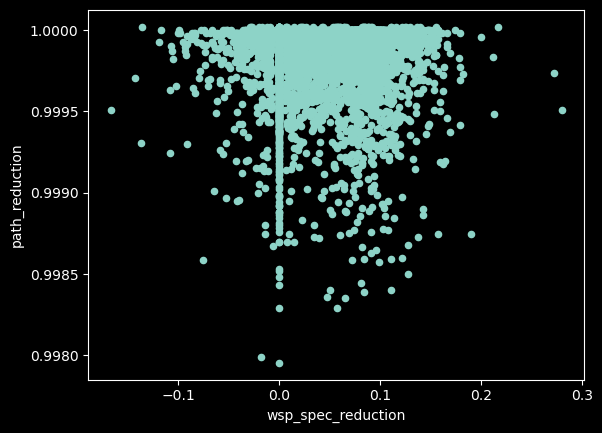

In [38]:
path_largest.plot.scatter("wsp_spec_reduction", "path_reduction")
results = sm.OLS(path_smallest["path_reduction"], sm.add_constant(path_smallest["wsp_spec_reduction"])).fit()
results.summary()

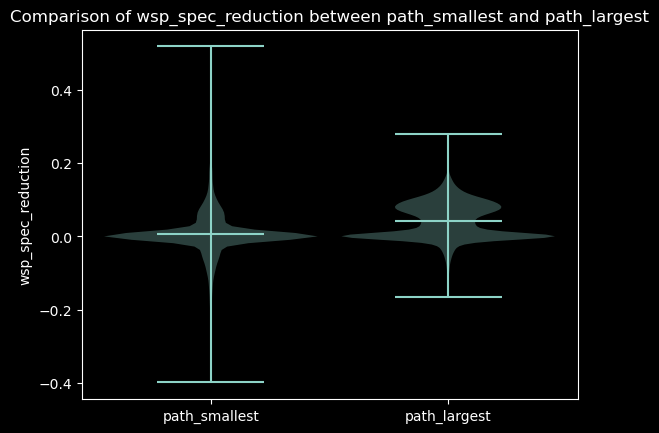

T-statistic: -30.4407, p-value: 3.723e-194
The means are statistically significantly different (p < 0.05).


In [41]:
# Create a DataFrame for violin plot comparison
violin_data = [
    path_smallest['wsp_spec_reduction'],
    path_largest['wsp_spec_reduction']
]

plt.violinplot(violin_data, showmedians=False, showmeans=True, showextrema=True, points=100, widths=0.9)
plt.xticks([1, 2], ['path_smallest', 'path_largest'])
plt.ylabel('wsp_spec_reduction')
plt.title('Comparison of wsp_spec_reduction between path_smallest and path_largest')
plt.show()

# Perform independent t-test
stat, p_value = ttest_ind(
    path_smallest['wsp_spec_reduction'],
    path_largest['wsp_spec_reduction'],
    nan_policy='omit',
    equal_var=False  # Use Welch's t-test if variances are unequal
)

print(f"T-statistic: {stat:.4f}, p-value: {p_value:.4g}")
if p_value < 0.05:
    print("The means are statistically significantly different (p < 0.05).")
else:
    print("No statistically significant difference between means (p >= 0.05).")

This is showing that the highest reduction (path smallest) are generally very much based around 0.

## How much does the wsps on a specific point actually matter

In [16]:
results = sm.OLS(reduction_df["path_reduction"], sm.add_constant(reduction_df["point_specific_wsp"])).fit()
print(results.summary())

results_B = sm.OLS(reduction_df["path_reduction"], sm.add_constant(reduction_df[["point_specific_wsp", "point_specific_wsp_B"]])).fit()
results_B.summary()

                            OLS Regression Results                            
Dep. Variable:         path_reduction   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     2367.
Date:                Sun, 08 Jun 2025   Prob (F-statistic):               0.00
Time:                        15:28:10   Log-Likelihood:             1.3831e+05
No. Observations:              100000   AIC:                        -2.766e+05
Df Residuals:                   99998   BIC:                        -2.766e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.9684      0

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                 1.582e+04
Date:                Sun, 08 Jun 2025   Prob (F-statistic):               0.00
Time:                        15:28:10   Log-Likelihood:             1.5088e+05
No. Observations:              100000   AIC:                        -3.018e+05
Df Residuals:                   99997   BIC:                        -3.017e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.9320      0.000   3302.708      0.000       0.931       0.933
point_specific_wsp       0.0101      0.000     32.682      0.000       0.010       0.011
point_specific_wsp_B     0.0058   3.42e-05    169.093      0.000       0.006       0.006
==============================================================================
Omnibus:                    66735.343   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           992113.080
Skew:                          -3.063   Prob(JB):                         0.00
Kurtosis:                      17.162   Cond. No.                         15.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
results2 = smf.ols(formula="path_reduction ~ point_specific_wsp + I(point_specific_wsp**2)", data=reduction_df).fit()
print(results2.summary())

results2_B = smf.ols(formula="path_reduction ~ point_specific_wsp + I(point_specific_wsp**2) + point_specific_wsp_B + I(point_specific_wsp_B**2)", data=reduction_df).fit()
results2_B.summary()

                            OLS Regression Results                            
Dep. Variable:         path_reduction   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     1554.
Date:                Sun, 08 Jun 2025   Prob (F-statistic):               0.00
Time:                        15:28:10   Log-Likelihood:             1.3867e+05
No. Observations:              100000   AIC:                        -2.773e+05
Df Residuals:                   99997   BIC:                        -2.773e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                 1.233e+04
Date:                Sun, 08 Jun 2025   Prob (F-statistic):               0.00
Time:                        15:28:10   Log-Likelihood:             1.5719e+05
No. Observations:              100000   AIC:                        -3.144e+05
Df Residuals:                   99995   BIC:                        -3.143e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.9100      0.000   2792.010      0.000       0.909       0.911
point_specific_wsp              -0.0003      0.001     -0.421      0.674      -0.002       0.001
I(point_specific_wsp ** 2)       0.0020      0.000      7.345      0.000       0.001       0.002
point_specific_wsp_B             0.0176      0.000    164.256      0.000       0.017       0.018
I(point_specific_wsp_B ** 2)    -0.0008   6.84e-06   -115.893      0.000      -0.001      -0.001
==============================================================================
Omnibus:                    61460.432   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           929043.345
Skew:                          -2.715   Prob(JB):                         0.00
Kurtosis:                      16.910   Cond. No.                         447.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_47090/3262848167.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


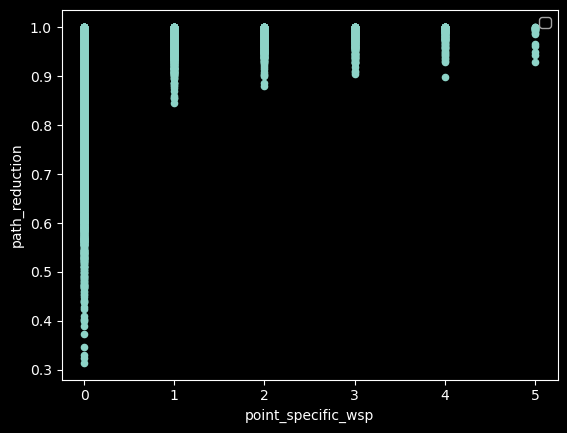

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_47090/3262848167.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.params[0]


np.float64(0.9683699654723739)

In [18]:
reduction_df.plot.scatter("point_specific_wsp", "path_reduction")
# Plot the first fitted model
# results = sm.OLS(reduction_df["path_reduction"], sm.add_constant(reduction_df["point_specific_wsp"])).fit()
# x = np.linspace(reduction_df["point_specific_wsp"].min(), reduction_df["point_specific_wsp"].max(), 100)
# y = results.params[0] + (results.params[1] * x)
# plt.plot(x, y, color='red', label='Linear Fit')

# Plot the second fitted model
# results2 = smf.ols(formula="path_reduction ~ point_specific_wsp + I(point_specific_wsp**2)", data=reduction_df).fit()
# y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2
# plt.plot(x, y2, color='blue', label='Quadratic Fit')

plt.legend()
plt.show()
results.params[0]

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_47090/631633804.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Z = 1 - (results2_B.params[0] + results2_B.params[1] * X + results2_B.params[2] * X**2 + results2_B.params[3] * Y + results2_B.params[4] * Y**2)


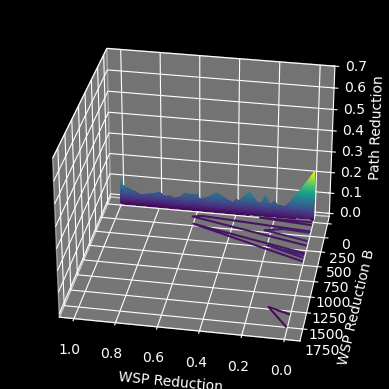

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
x = np.linspace(reduction_df["point_specific_wsp_weighted"].min(), reduction_df["point_specific_wsp_weighted"].max(), 100)
y = np.linspace(reduction_df["point_specific_wsp_weighted_B"].min(), reduction_df["point_specific_wsp_weighted_B"].max(), 100)
X, Y = np.meshgrid(x, y)
Z = 1 - (results2_B.params[0] + results2_B.params[1] * X + results2_B.params[2] * X**2 + results2_B.params[3] * Y + results2_B.params[4] * Y**2)
# ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.5)
# Plot the scatter points
# ax.scatter(reduction_df["point_specific_wsp_weighted"], reduction_df["point_specific_wsp_weighted_B"], 1 - reduction_df["path_reduction"], color='r', alpha=0.1)
ax.tricontour(reduction_df["point_specific_wsp_weighted"], reduction_df["point_specific_wsp_weighted_B"], 1 - reduction_df["path_reduction"], 40, cmap='viridis')
ax.set_xlabel('WSP Reduction')
ax.set_ylabel('WSP Reduction B')
ax.set_zlabel('Path Reduction')

ax.view_init(azim=100, elev=30)

plt.show()

<Axes: >

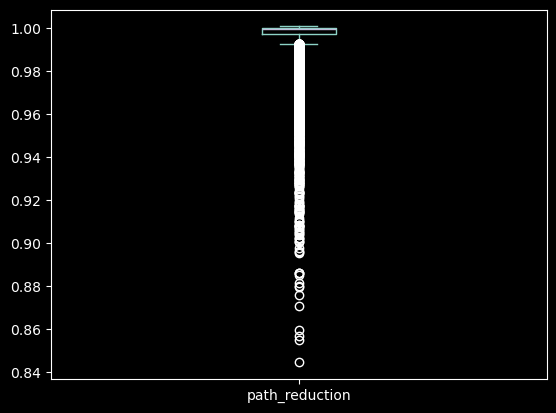

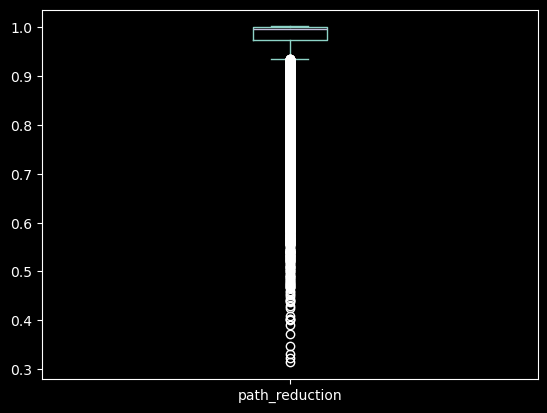

In [20]:
median = reduction_df['point_specific_wsp'].median()

reduction_df[reduction_df['point_specific_wsp'] > median].plot.box(y='path_reduction')
reduction_df[reduction_df['point_specific_wsp'] <= median].plot.box(y='path_reduction')

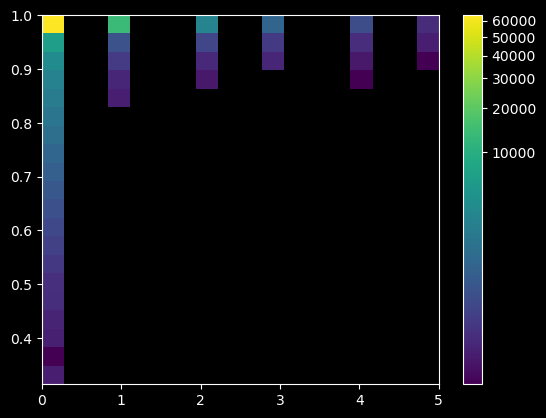

In [21]:
h = plt.hist2d(reduction_df["point_specific_wsp"], reduction_df["path_reduction"], bins=(18,20), cmin=1, norm=PowerNorm(0.25))
plt.colorbar(h[3])

## How well do other geometric tools work for this

In [22]:
variable = "point_maximum_cost_weighted"

results = sm.OLS(reduction_df["path_reduction"], sm.add_constant(reduction_df[variable])).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                 4.435e+04
Date:                Sun, 08 Jun 2025   Prob (F-statistic):               0.00
Time:                        15:28:11   Log-Likelihood:             1.5549e+05
No. Observations:              100000   AIC:                        -3.110e+05
Df Residuals:                   99998   BIC:                        -3.110e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           1.1238      0.001   1522.574      0.000       1.122       1.125
point_maximum_cost_weighted    -0.5878      0.003   -210.584      0.000      -0.593      -0.582
==============================================================================
Omnibus:                    52041.230   Durbin-Watson:                   1.750
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           511892.201
Skew:                          -2.315   Prob(JB):                         0.00
Kurtosis:                      13.071   Cond. No.                         18.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
results2 = smf.ols(formula=f"path_reduction ~ {variable} + I({variable}**2)", data=reduction_df).fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                 2.987e+04
Date:                Sun, 08 Jun 2025   Prob (F-statistic):               0.00
Time:                        15:28:11   Log-Likelihood:             1.6056e+05
No. Observations:              100000   AIC:                        -3.211e+05
Df Residuals:                   99997   BIC:                        -3.211e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.8394      0.003    295.374      0.000       0.834       0.845
point_maximum_cost_weighted             1.5332      0.021     74.032      0.000       1.493       1.574
I(point_maximum_cost_weighted ** 2)    -3.7591      0.036   -103.267      0.000      -3.830      -3.688
==============================================================================
Omnibus:                    46136.273   Durbin-Watson:                   1.756
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           455943.213
Skew:                          -1.978   Prob(JB):                         0.00
Kurtosis:                      12.684   Cond. No.                         282.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_47090/1114625799.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = results.params[0] + (results.params[1] * x)
/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_47090/1114625799.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2


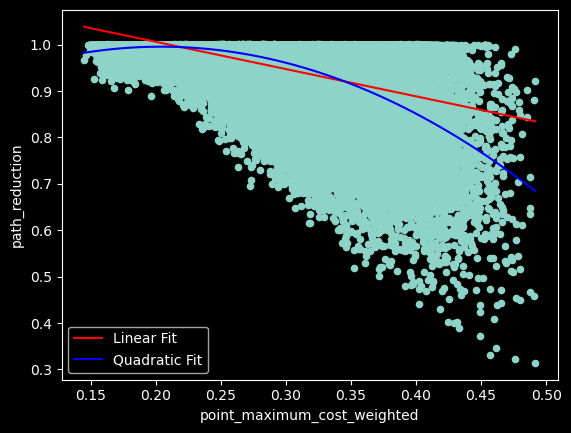

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_47090/1114625799.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.params[0]


np.float64(1.1238436087493986)

In [24]:
reduction_df.plot.scatter(variable, "path_reduction")
# Plot the first fitted model
x = np.linspace(reduction_df[variable].min(), reduction_df[variable].max(), 100)
y = results.params[0] + (results.params[1] * x)
plt.plot(x, y, color='red', label='Linear Fit')

# Plot the second fitted model
y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2
plt.plot(x, y2, color='blue', label='Quadratic Fit')

plt.legend()
plt.show()
results.params[0]

In [25]:
results2 = smf.ols(formula=f"optimal_percent ~ point_specific_wsp_weighted + I(point_specific_wsp_weighted**2) + point_average_cost_weighted + I(point_average_cost_weighted**2) + point_maximum_cost_weighted + point_maximum_cost_weighted + I(point_maximum_cost_weighted**2) + point_minimum_cost_weighted", data=reduction_df).fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        optimal_percent   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                 5.525e+04
Date:                Sun, 08 Jun 2025   Prob (F-statistic):               0.00
Time:                        15:28:11   Log-Likelihood:             1.7784e+05
No. Observations:              100000   AIC:                        -3.557e+05
Df Residuals:                   99992   BIC:                        -3.556e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.2368      0.002     97.105      0.000       0.232       0.242
point_specific_wsp_weighted             0.0353      0.002     18.631      0.000       0.032       0.039
I(point_specific_wsp_weighted ** 2)    -0.0247      0.002    -12.107      0.000      -0.029      -0.021
point_average_cost_weighted            -1.8744      0.011   -167.310      0.000      -1.896      -1.852
I(point_average_cost_weighted ** 2)     5.7837      0.037    155.494      0.000       5.711       5.857
point_maximum_cost_weighted            -1.2919      0.018    -70.019      0.000      -1.328      -1.256
I(point_maximum_cost_weighted ** 2)     2.5886      0.033     77.998      0.000       2.524       2.654
point_minimum_cost_weighted             1.9056      0.007    280.426      0.000       1.892       1.919
==============================================================================
Omnibus:                    41421.816   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3649155.469
Skew:                           1.083   Prob(JB):                         0.00
Kurtosis:                      32.514   Cond. No.                         358.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
pca = sm.PCA(reduction_df[["point_specific_wsp_weighted", "point_average_cost_weighted", "point_maximum_cost_weighted", "point_minimum_cost_weighted"]][:5000].T)

pca.factors

,comp_0,comp_1,comp_2,comp_3
point_specific_wsp_weighted,-0.509257,0.700224,-0.018510,-0.535074
point_average_cost_weighted,0.005672,-0.373556,-0.781296,0.534709
point_maximum_cost_weighted,0.805790,0.234652,0.213639,-0.051937
point_minimum_cost_weighted,-0.302205,-0.561320,0.586168,0.046420


<Axes: xlabel='point_specific_wsp_weighted', ylabel='point_maximum_cost_weighted'>

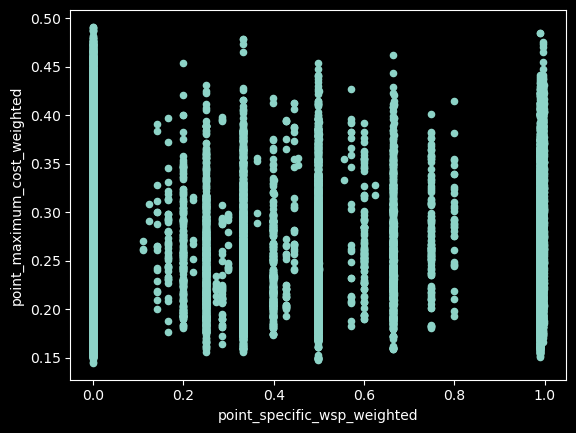

In [27]:
reduction_df.plot.scatter("point_specific_wsp_weighted", "point_maximum_cost_weighted")